# Demonstrating DAGs with Instrumental Variables

This notebook covers:
- Creating a DAG with an instrumental variable
- Simulating data
- Estimating causal effect using instrumental variables
- Visualizing the DAG

In [1]:
# Install required libraries (uncomment if running in a new environment)
!pip install numpy pandas matplotlib networkx statsmodels

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm

## Create a DAG with an Instrumental Variable

We'll define a DAG where Z is an instrumental variable for the effect of X on Y.

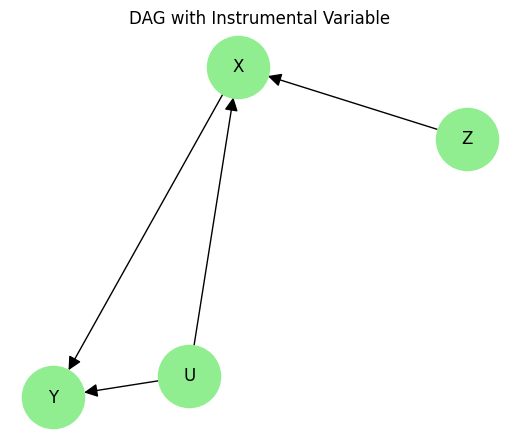

In [3]:
# Create and plot the DAG
G = nx.DiGraph()
G.add_edges_from([
    ('Z', 'X'),  # Instrumental variable
    ('X', 'Y'),  # Treatment effect
    ('U', 'X'),  # Unobserved confounder
    ('U', 'Y')   # Unobserved confounder
])
plt.figure(figsize=(5,4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=2000, arrowsize=20)
plt.title('DAG with Instrumental Variable')
plt.show()

## Simulate Data for Instrumental Variable Analysis

We'll simulate data where Z affects X, X affects Y, and U is an unobserved confounder.

In [4]:
# Simulate data
np.random.seed(42)
n = 500
U = np.random.normal(0, 1, n)  # Unobserved confounder
Z = np.random.binomial(1, 0.5, n)  # Instrument
X = 0.7*Z + 0.5*U + np.random.normal(0, 1, n)  # Treatment
Y = 1.2*X + 0.8*U + np.random.normal(0, 1, n)  # Outcome

data = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})
data.head()

,Z,X,Y
0,1,0.781239,-0.012268
1,1,0.777582,-0.149128
2,0,1.530353,3.554989
3,1,0.644579,1.335025
4,1,0.951597,-0.092318


## Estimate Causal Effect Using Instrumental Variables

We'll use two-stage least squares (2SLS) to estimate the effect of X on Y using Z as an instrument.

In [5]:
# Two-stage least squares (2SLS) estimation
from statsmodels.sandbox.regression.gmm import IV2SLS

# First stage: regress X on Z
first_stage = sm.OLS(data['X'], sm.add_constant(data['Z'])).fit()
print('First stage: X ~ Z')
print(first_stage.summary())

# Second stage: regress Y on predicted X
data['X_hat'] = first_stage.predict(sm.add_constant(data['Z']))
second_stage = sm.OLS(data['Y'], sm.add_constant(data['X_hat'])).fit()
print('\nSecond stage: Y ~ X_hat')
print(second_stage.summary())

# Direct IV2SLS estimation
iv = IV2SLS(data['Y'], sm.add_constant(data['X']), data['Z']).fit()
print('\nIV2SLS estimation:')
print(iv.summary())

First stage: X ~ Z
                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     47.87
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           1.40e-11
Time:                        13:50:09   Log-Likelihood:                -763.06
No. Observations:                 500   AIC:                             1530.
Df Residuals:                     498   BIC:                             1539.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0738      0.071 

## Interpretation

The estimated coefficient of X from the IV2SLS model represents the causal effect of X on Y, accounting for unobserved confounding via the instrument Z.